In [75]:
import sys
import pickle as pl
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
import seaborn as sns
from getdist import plots, MCSamples
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2
from quest import Reconstruction

In [3]:
rec1 = Reconstruction.from_ini('LB_FG0.ini')
rec2 = Reconstruction.from_ini('LB_FG1.ini')
rec3 = Reconstruction.from_ini('LB_FG2.ini')

DATABASE: loaded
SIMUALATION object with out FG: Loaded
FILTERING object with out FG: Loaded
QUEST object with out FG: Loaded
DATABASE: loaded
SIMUALATION object with  FG: Loaded
FILTERING object with  FG: Loaded
QUEST object with  FG: Loaded
DATABASE: loaded
SIMUALATION object with  FG: Loaded
FILTERING object with  FG: Loaded
QUEST object with  FG: Loaded


In [4]:
pvalue = pl.load(open('pvalue.pkl','rb'))
s0d0 = pvalue['s0d0']
s1d1 = pvalue['s1d1']

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

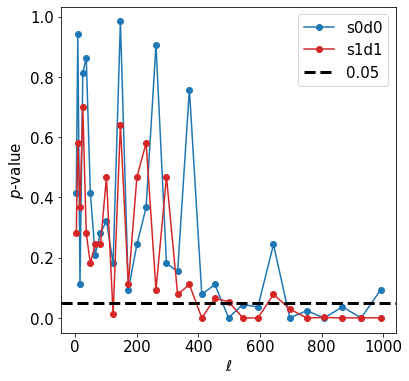

In [5]:
plt.figure(figsize=(6,6))
plt.plot(rec1.B,s0d0,label='s0d0',marker='o',c='C10')
plt.plot(rec1.B,s1d1,label='s1d1',marker='o',c='C3')
plt.axhline(0.05,color='k',ls='--',label='0.05',lw=3)
plt.legend(fontsize=15)
plt.ylabel('$p$-value',fontsize=15)
plt.xlabel('$\ell$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [6]:
fiducial = rec1.bin_cell(rec1.cl_pp*rec1.Lfac)

In [7]:
qcl1 = rec1.get_qcl_wR_stat(n=400,n1=True,rdn0=True)
qcl2 = rec2.get_qcl_wR_stat(n=400,n1=True,rdn0=True)
qcl3 = rec3.get_qcl_wR_stat(n=400,n1=True,rdn0=True)
qcl1m = np.mean(qcl1,axis=0)
qcl2m = np.mean(qcl2,axis=0)
qcl3m = np.mean(qcl3,axis=0)
qcl1_icov = np.linalg.inv(np.cov(qcl1.T))
qcl2_icov = np.linalg.inv(np.cov(qcl2.T))
qcl3_icov = np.linalg.inv(np.cov(qcl3.T))

In [8]:
fg0mcn0 = rec1.Lfac*(rec1.RDN0_mean()/rec1.response_mean()**2)
fg1mcn0 = rec2.Lfac*(rec2.RDN0_mean()/rec2.response_mean()**2)
fg2mcn0 = rec3.Lfac*(rec3.RDN0_mean()/rec3.response_mean()**2)

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
dn0_fg1 = rec1.bin_cell(fg1mcn0 - fg0mcn0)
dn0_fg2 = rec1.bin_cell(fg2mcn0 - fg0mcn0)

In [10]:
def chi_sq(alens,which,delta=False):
    if which=='nofg':
        qcl = qcl1m.copy()
        icov = qcl1_icov
    elif which=='fg1':
        qcl = qcl2m.copy()
        if delta:
            qcl += dn0_fg1
        icov = qcl2_icov
    elif which=='fg2':
        qcl = qcl3m.copy()
        if delta:
            qcl += dn0_fg2
        icov = qcl3_icov
    else:
        raise ValueError('which must be nofg, fg1, or fg2')
    
    dcl = qcl - (alens*fiducial)
    return np.dot(dcl,np.dot(icov,dcl))


def log_prior(theta):
    if 0.5 < theta < 1.5:
        return 0.0
    return -np.inf

def log_likelihood(theta,which,delta=False):
    return -0.5 * chi_sq(theta,which,delta)

def log_probability(theta,which,delta=False):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,which,delta)

In [11]:
def get_samples(which,delta=False):
    pos = [1] + 1e-1 * np.random.randn(64, 1)
    nwalkers,ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers,ndim,log_probability,args=[which,delta])
    sampler.run_mcmc(pos, 4000, progress=True)
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    return flat_samples

In [12]:
nofg_samp = get_samples('nofg')
fg1_samp = get_samples('fg1')
fg2_samp = get_samples('fg2')

100%|██████████| 4000/4000 [00:03<00:00, 1030.26it/s]


In [13]:
np.std(fg2_samp)

0.02333683112868334

In [14]:
1/0.0233

42.918454935622314

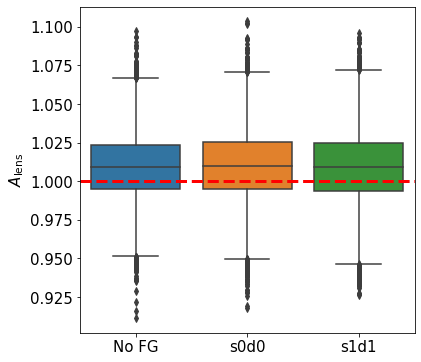

In [15]:
data_to_plot = [nofg_samp, fg1_samp, fg2_samp]
labels = ['No FG', 's0d0', 's1d1']

plt.figure(figsize=(6, 6))
sns.boxplot(data=data_to_plot)
plt.xticks(range(len(labels)),labels,fontsize=15)
plt.ylabel('$A_{\mathrm{lens}}$',fontsize=15)
plt.axhline(1,color='r',ls='--',lw=3)
plt.yticks(fontsize=15)
plt.show()

In [16]:
fg1_samp_delta = get_samples('fg1',delta=True)
fg2_samp_delta = get_samples('fg2',delta=True)

100%|██████████| 4000/4000 [00:04<00:00, 944.06it/s]


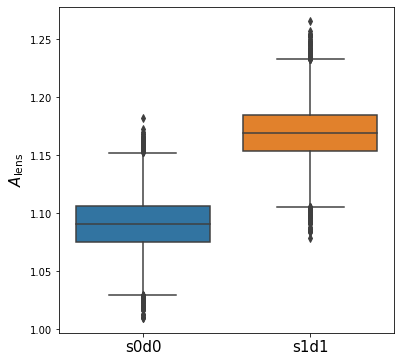

In [17]:
data_delta = [fg1_samp_delta, fg2_samp_delta]
labels_d = ['s0d0', 's1d1']

plt.figure(figsize=(6, 6))
sns.boxplot(data=data_delta)
plt.xticks(range(len(labels_d)),labels_d,fontsize=15)
plt.ylabel('$A_{\mathrm{lens}}$',fontsize=15)
plt.show()

In [18]:
df = pd.DataFrame({ 'No FG': nofg_samp.reshape(-1),
                    's0d0':fg1_samp_delta.reshape(-1),
                   's1d1':fg2_samp_delta.reshape(-1)})

df2 = df.melt().assign(x='vars')
df2.rename(columns={'variable':'Model','value':'Alens'},inplace=True)

<AxesSubplot:xlabel='x', ylabel='Alens'>

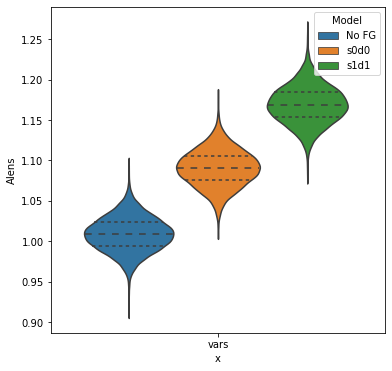

In [19]:
plt.figure(figsize=(6, 6))
sns.violinplot(data=df2, x='x', y='Alens', 
               hue='Model', inner='quart')

In [20]:
sdata = { 'No FG': nofg_samp.reshape(-1),
          's0d0':fg1_samp_delta.reshape(-1),
        's1d1':fg2_samp_delta.reshape(-1)}

In [21]:
names = ["Alens"]
labels =  ["A_\mathrm{lens}"]
nofg_mc = MCSamples(samples=sdata['No FG'],names=names,labels=labels, label='No FG')
fg1_mc = MCSamples(samples=sdata['s0d0'],names=names,labels=labels, label='s0d0')
fg2_mc = MCSamples(samples=sdata['s1d1'],names=names,labels=labels, label='s1d1')


Removed no burn in
Removed no burn in
Removed no burn in


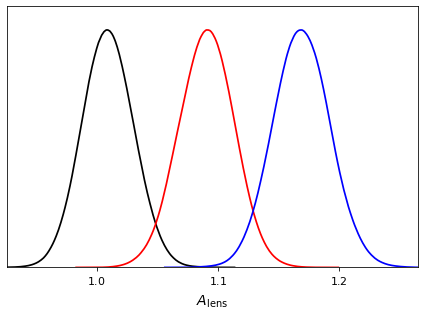

In [22]:
g = plots.get_single_plotter(width_inch=6)
g.plot_1d([nofg_mc,fg1_mc,fg2_mc], 'Alens')

In [23]:
from scipy.stats import gaussian_kde

In [24]:
def find_density(arr):
    density = gaussian_kde(arr,.3)
    xs = np.linspace(min(arr),max(arr),1000)
    ds = density(xs)
    return xs,ds/max(ds)

In [25]:
sm1 = sdata['No FG'].mean()
sm2 = sdata['s0d0'].mean()
sm3 = sdata['s1d1'].mean()

In [26]:
bias1 = (sm2-sm1/sm1)*100
bias2 = (sm3-sm1/sm1)*100

In [27]:
bias2

16.909303924612317

([], [])

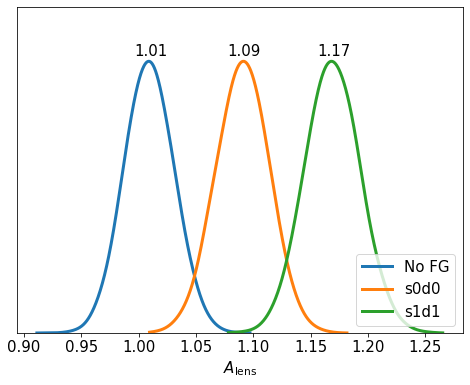

In [28]:
plt.figure(figsize=(8,6))
plt.plot(*find_density(sdata['No FG']),lw=3,label='No FG')
plt.plot(*find_density(sdata['s0d0']),lw=3,label='s0d0')
plt.plot(*find_density(sdata['s1d1']),lw=3,label='s1d1')
plt.text(sm1-.013,1.02,f"{sm1:.2f}",fontsize=15)
plt.text(sm2-.013,1.02,f"{sm2:.2f}",fontsize=15)
plt.text(sm3-.013,1.02,f"{sm3:.2f}",fontsize=15)
plt.xlabel('$A_\mathrm{lens}$',fontsize=15)
plt.ylim(0,1.2)
plt.legend(fontsize=15,loc='lower right')
plt.xticks(fontsize=15)
plt.yticks([])

In [57]:
class crazymix:
    
    def __init__(self,s1d1,other,idx=0,do_MC=False):
        self.s1d1 = s1d1
        self.other = other
        self.idx = idx
        self.B = self.s1d1.B
        self.do_MC = do_MC
        self.fiducial = self.other.bin_cell(self.other.cl_pp*self.other.Lfac)
        self.icov = self.icov_()
        self.spectra = self.get_spectra()
        
    def get_data(self):
        return self.s1d1.get_phi_cl(self.idx)
    
    def get_spectra(self):
        
        if self.do_MC:
            N0 = self.other.MCN0()
            correction =N0*0
        else:
            N0 = self.other.RDN0(self.idx)
            correction = ((N0/self.other.response_mean()**2)+self.other.cl_pp)/100
        
        cl = (self.get_data() - 
              self.other.N1 - 
              N0)/self.other.response_mean()**2
    
        
        
        return self.other.bin_cell((cl-correction)*self.s1d1.Lfac)
    
    def icov_(self):
        return np.linalg.inv(np.cov(self.other.get_qcl_wR_stat().T))
    
    def chi_sq(self,alens):
        dcl = self.spectra - (alens*self.fiducial)
        return np.dot(dcl,np.dot(self.icov,dcl))
    
    
    def log_prior(self,theta):
        if 0.5 < theta < 1.5:
            return 0.0
        return -np.inf

    def log_likelihood(self,theta,):
        return -0.5 * self.chi_sq(theta)

    def log_probability(self,theta):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(theta)
    
    def get_samples(self):
        pos = [1] + 1e-1 * np.random.randn(64, 1)
        nwalkers,ndim = pos.shape
        sampler = emcee.EnsembleSampler(nwalkers,ndim,self.log_probability)
        sampler.run_mcmc(pos, 4000, progress=True)
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
        return flat_samples

In [77]:
c = crazymix(rec3,rec1,100)
snofg = c.get_samples().reshape(-1)

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 4000/4000 [00:03<00:00, 1065.88it/s]


In [76]:
c = crazymix(rec3,rec2,100)
sfg1 = c.get_samples().reshape(-1)

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 4000/4000 [00:03<00:00, 1069.77it/s]


In [78]:
c = crazymix(rec3,rec3,100)
sfg2 = c.get_samples().reshape(-1)

/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/pscratch/sd/l/lonappan/software_pkgs/cmblens/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 4000/4000 [00:03<00:00, 1044.14it/s]


In [79]:
smm1=np.mean(snofg)
smm2=np.mean(sfg1)
smm3=np.mean(sfg2)

([], [])

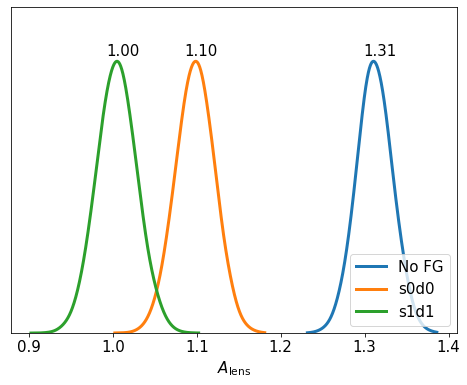

In [80]:
plt.figure(figsize=(8,6))
plt.plot(*find_density(snofg),lw=3,label='No FG')
plt.plot(*find_density(sfg1),lw=3,label='s0d0')
plt.plot(*find_density(sfg2),lw=3,label='s1d1')
plt.text(smm1-.013,1.02,f"{smm1:.2f}",fontsize=15)
plt.text(smm2-.013,1.02,f"{smm2:.2f}",fontsize=15)
plt.text(smm3-.013,1.02,f"{smm3:.2f}",fontsize=15)
plt.xlabel('$A_\mathrm{lens}$',fontsize=15)
plt.ylim(0,1.2)
plt.legend(fontsize=15,loc='lower right')
plt.xticks(fontsize=15)
plt.yticks([])